In [25]:
from pathlib import Path

import pandas as pd

from portfolio_factor_allocation.backtesting import (
    calculate_annualized_volatility,
    calculate_information_ratio,
    calculate_sharpe_ratio,
    calculate_strategy_returns,
    calculate_tracking_error,
)

In [26]:
data_dir = Path.cwd().parent / "data"
strategies_dir = data_dir / "strategies"
returns_dir = data_dir / "returns"
summary_dir = data_dir / "summary"

returns_dir.mkdir(parents=True, exist_ok=True)
summary_dir.mkdir(parents=True, exist_ok=True)

### Load data

Retrieve sample df_weights to be able to remove unnecessary companies from df_crsp

In [27]:
df_monthly_returns = pd.read_csv(data_dir / "monthly_returns.csv", parse_dates=["date"])
df_monthly_returns["date"] = df_monthly_returns["date"].dt.to_period("M")
df_monthly_rf = pd.read_csv(data_dir / "monthly_rf.csv", parse_dates=["date"])
df_monthly_rf["date"] = df_monthly_rf["date"].dt.to_period("M")

### Compute returns

In [28]:
factor_combs = [["V", "W"]]
suffixes = [
    "_int_ter",
    "_mix_ter",
    "_int_dec",
    "_mix_dec",
    "_int_bw",
    "_mix_bw",
]
year_shift = 1
n_month_rebalance = 1

In [29]:
df_weights = pd.read_csv(data_dir / "strategies" / "market.csv")

df_market_r = calculate_strategy_returns(
    df_weights, df_monthly_returns, year_shift, n_month_rebalance, ["market"]
)

df_market_r.to_csv(returns_dir / "market.csv", index=False)

In [30]:
vol_data = {}
sharpe_data = {}
ir_data = {}
te_data = {}

# Ensure market returns are indexed by date for alignment
market_series = df_market_r.set_index("date")["market"]
rf_series = df_monthly_rf.set_index("date")["rf"]

for factor_comb in factor_combs:
    factor_str = "_".join(factor_comb)
    weights_cols = [factor_str + s for s in suffixes]
    df_weights = pd.read_csv(strategies_dir / f"{factor_str}.csv")

    df_r = calculate_strategy_returns(
        df_weights, df_monthly_returns, year_shift, n_month_rebalance, weights_cols
    )

    df_r.to_csv(returns_dir / f"{factor_str}.csv", index=False)

    # Calculate stats
    df_r_indexed = df_r.set_index("date")

    # Align with market and rf
    # We need to align all three: strategy returns, market returns, and risk-free rate
    # to ensure we are calculating metrics on the exact same set of dates.
    common_index = df_r_indexed.index.intersection(market_series.index).intersection(
        rf_series.index
    )

    aligned_r = df_r_indexed.loc[common_index]
    aligned_m = market_series.loc[common_index]
    aligned_rf = rf_series.loc[common_index]

    vols = {}
    sharpes = {}
    irs = {}
    tes = {}

    for col, suffix in zip(weights_cols, suffixes):
        # Returns for this strategy
        r = aligned_r[col]

        # Vol
        vols[suffix] = calculate_annualized_volatility(r)

        # Sharpe
        sharpes[suffix] = calculate_sharpe_ratio(r, aligned_rf)

        # IR
        irs[suffix] = calculate_information_ratio(r, aligned_m)

        # TE
        tes[suffix] = calculate_tracking_error(r, aligned_m)

    vol_data[factor_str] = vols
    sharpe_data[factor_str] = sharpes
    ir_data[factor_str] = irs
    te_data[factor_str] = tes

df_vol = pd.DataFrame(vol_data)
df_sharpe = pd.DataFrame(sharpe_data)
df_ir = pd.DataFrame(ir_data)
df_te = pd.DataFrame(te_data)

df_vol.to_csv(summary_dir / "vol_summary.csv")
df_sharpe.to_csv(summary_dir / "sharpe_summary.csv")
df_ir.to_csv(summary_dir / "ir_summary.csv")
df_te.to_csv(summary_dir / "te_summary.csv")

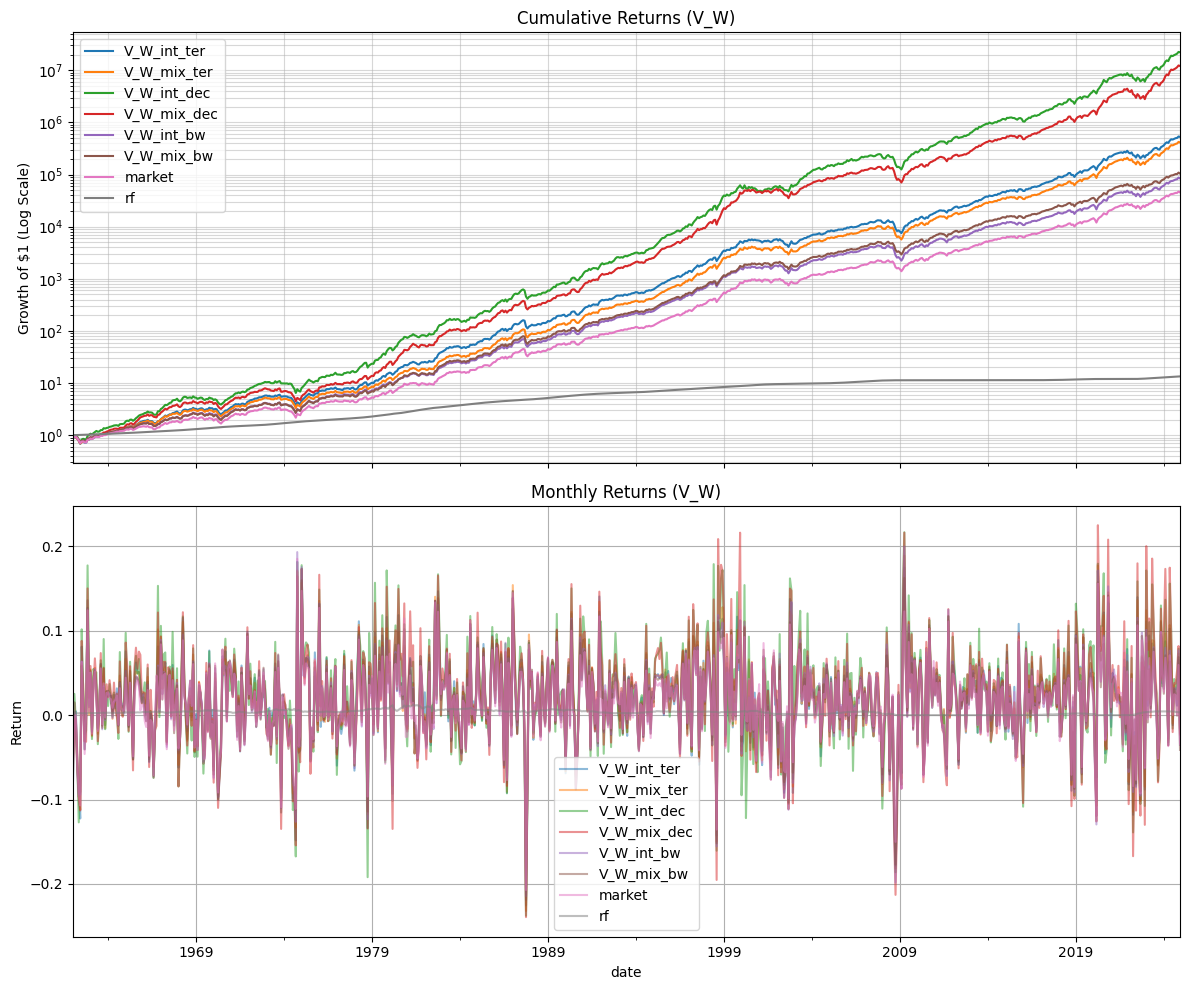

In [31]:
import matplotlib.pyplot as plt

# Plotting the last processed factor combination
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Prepare data
# Join strategy returns with market returns
df_plot = df_r.set_index("date").join(df_market_r.set_index("date"), how="inner")
df_plot = df_plot.join(df_monthly_rf.set_index("date"), how="inner")
df_cum = (1 + df_plot).cumprod()

# Cumulative Returns (Log Scale)
df_cum.plot(ax=axes[0], title=f"Cumulative Returns ({factor_str})", logy=True)
axes[0].set_ylabel("Growth of $1 (Log Scale)")
axes[0].grid(True, which="both", ls="-", alpha=0.5)

# Monthly Returns
df_plot.plot(ax=axes[1], title=f"Monthly Returns ({factor_str})", alpha=0.5)
axes[1].set_ylabel("Return")
axes[1].grid(True)

plt.tight_layout()
plt.show()

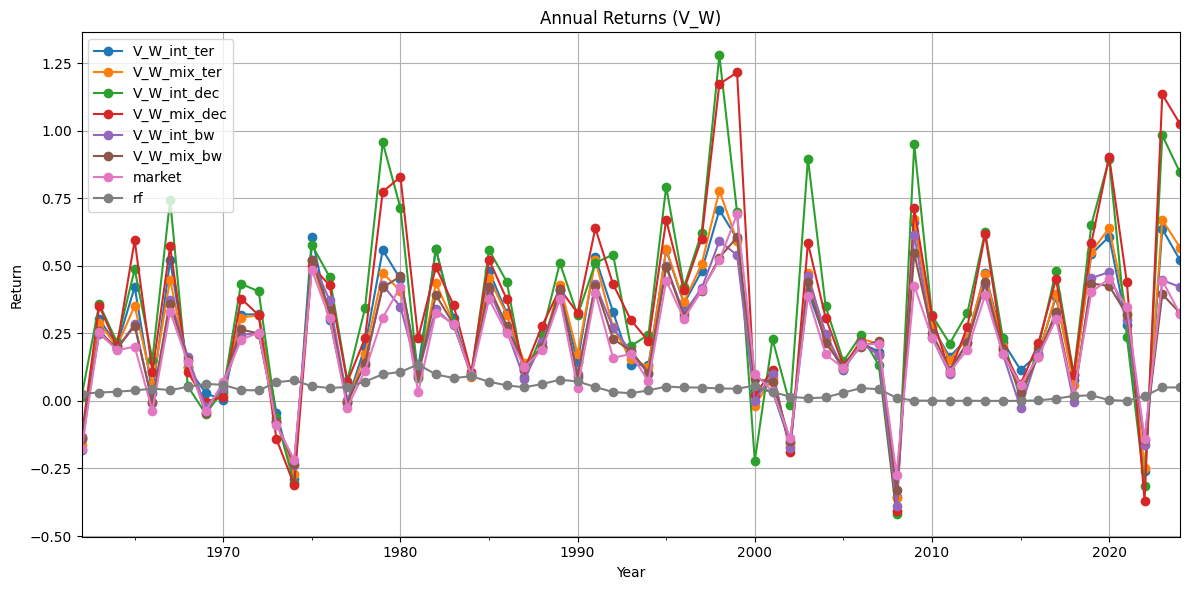

In [32]:
# Annual Returns
# Resample to annual frequency and compound returns
df_annual = (1 + df_plot).resample("Y").prod() - 1

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
df_annual.plot(ax=ax, title=f"Annual Returns ({factor_str})", marker="o")
ax.set_ylabel("Return")
ax.set_xlabel("Year")
ax.grid(True)
plt.tight_layout()
plt.show()